In [23]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

Даны 6 таблиц, 3 для обучения и аналогичные 3 для теста.    
Первая содержит данные биржи:   
__Date__ - дата наблюдения,   
__Open__ - индекс на момент открытия биржи,   
__High__ - максимальный индекс за день,   
__Low__ - минимальный индекс за день,   
__Close__ - индекс на момент закрытия биржи (целевая переменная),   
__Volume__ - количество сделок,   
__Adj Close__ - скорректированный индекс закрытия.   


In [26]:
table_train = pd.read_csv('data/DJIA_Table(train).csv')
table_test = pd.read_csv('data/DJIA_Table(test).csv')
table_train['Date'] = pd.to_datetime(table_train['Date'], dayfirst=True)
table_test['Date'] = pd.to_datetime(table_test['Date'], dayfirst=True)
print(table_train.shape)
print(table_test.shape)
table_train.head(1)

(1863, 7)
(126, 5)


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-31,17590.66016,17590.66016,17421.16016,17425.0293,93690000,17425.0293


Вторая содержит топ 25 заголовков новостей на соответствующую дату. __Label__ принимает значение "1", когда значение __Adj Close__ увеличивается или остается неизменным, и "0", когда значение __Adj Close__ уменьшается.

In [29]:
news_train = pd.read_csv('data/Combined_News_DJIA(train).csv')
news_test = pd.read_csv('data/Combined_News_DJIA(test).csv')
news_train['Date'] = pd.to_datetime(news_train['Date'])
news_test['Date'] = pd.to_datetime(news_test['Date'], dayfirst=True)
print(news_train.shape)
print(news_test.shape)
news_train.head(1)

(1989, 27)
(126, 27)


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""


В третьей таблице тоже заголовки новостей.

In [32]:
reddit_train = pd.read_csv('data/Reddit_News(train).csv')
reddit_test = pd.read_csv('data/Reddit_News(test).csv')
reddit_train['Date'] = pd.to_datetime(reddit_train['Date'])
reddit_test['Date'] = pd.to_datetime(reddit_test['Date'])
print(reddit_train.shape)
print(reddit_test.shape)
reddit_train.head(1)

(73608, 2)
(4551, 2)


,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...


Начнем с первой таблицы. Колонка __Adj Close__ дублирует колонку __Close__, поэтому ее можно будет убрать.

In [13]:
table_train[table_train['Close'] != table_train['Adj Close']]

,Date,Open,High,Low,Close,Volume,Adj Close


Поскольку значения колонок __Open__, __High__, __Low__ похожи, они будут коррелировать, что может сказаться на качестве обучения модели.   
Вычтем из колонок __High__ и __Low__ колонку __Open__ и сложим результаты. Получим разницу значений, на которую увеличивался и уменьшался индекс за день.   
Назовем колонку __Diff__.

In [16]:
table_train['High'] = table_train['High'] - table_train['Open']
table_train['Low'] = table_train['Low'] - table_train['Open']
table_train['Diff'] = table_train['High'] + table_train['Low']
table_train = table_train.drop(['Adj Close', 'High', 'Low'], axis=1)
table_test['High'] = table_test['High'] - table_test['Open']
table_test['Low'] = table_test['Low'] - table_test['Open']
table_test['Diff'] = table_test['High'] + table_test['Low']
table_test = table_test.drop([ 'High', 'Low'], axis=1)
table_train.head()

,Date,Open,Close,Volume,Diff
0,2015-12-31,17590.66016,17425.02930,93690000,-169.50000
1,2015-12-30,17711.93945,17603.86914,59760000,-120.87890
2,2015-12-29,17547.36914,17720.98047,69860000,202.65039
3,2015-12-28,17535.66016,17528.26953,59770000,-97.08009
4,2015-12-24,17593.25977,17552.16992,40350000,-36.23048


Посмотрим на карту корреляции.

<Axes: >

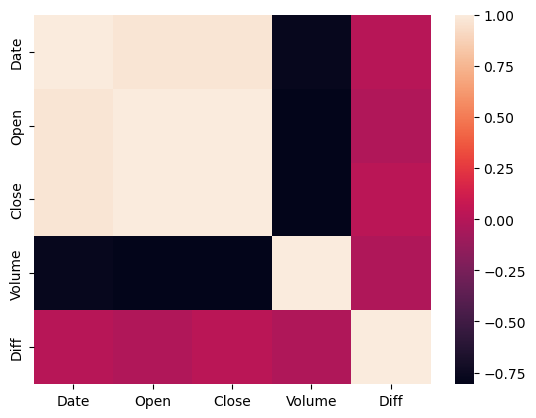

In [19]:
import seaborn as sns

sns.heatmap(table_train.corr(method='spearman'))

In [20]:
cor = table_train.corr(method='spearman')
cor[((cor > 0.5) | (cor < -0.5)) & (cor != 1)].dropna(how='all')

,Date,Open,Close,Volume,Diff
Date,NaN,0.967654,0.967964,-0.777282,NaN
Open,0.967654,NaN,0.998521,-0.804598,NaN
Close,0.967964,0.998521,NaN,-0.807224,NaN
Volume,-0.777282,-0.804598,-0.807224,NaN,NaN


Стоит убрать колонку __Volume__, поскольку она сильно коррелирует с колонкой __Open__, а на целевую __Close__ оказывает меньшее влияние.   
Поскольку даны две таблицы с текстами, проверим их на похожесть.

In [24]:
table_news = table_train[['Date', 'Open']].merge(news_train, on='Date', how='left')
table_news.isna().sum().sort_values(ascending=False).head()

Top25    3
Top24    3
Top23    1
Open     0
Top22    0
dtype: int64

In [26]:
table_reddit = table_train[['Date', 'Open']].merge(reddit_train, on='Date', how='left')
table_reddit.isna().sum().sort_values(ascending=False).head() 

Date    0
Open    0
News    0
dtype: int64

In [28]:
top_train = table_news.drop(['Date', 'Label', 'Open'], axis=1)
top_train = top_train.to_numpy().flatten()
top_train = pd.Series(top_train)
print(top_train.shape)
print(table_reddit.shape)

(46575,)
(46568, 3)


У обоих таблиц пропущенных дат нет, только 7 пропущенных новостей. Если не считать эти пропуски, количество новостей одинаковое.

In [31]:
def conv_str(s):
    f = filter(str.isalpha, s)
    return "".join(f).lower()

table_reddit['News'] = table_reddit['News'].astype('str').map(conv_str)
top_train = top_train.astype('str').map(conv_str)
table_reddit[~table_reddit['News'].isin(top_train)]

,Date,Open,News


Сами тексты тоже совпадают.

In [34]:
table_news = table_test[['Date', 'Open']].merge(news_test, on='Date', how='left')
table_news.isna().sum().sort_values(ascending=False).head()

Date     0
Open     0
Top24    0
Top23    0
Top22    0
dtype: int64

In [36]:
table_reddit = table_test[['Date', 'Open']].merge(reddit_test, on='Date', how='left')
table_reddit.isna().sum().sort_values(ascending=False).head() 

Date    0
Open    0
News    0
dtype: int64

In [38]:
top_train = table_news.drop(['Date', 'Label', 'Open'], axis=1)
top_train = top_train.to_numpy().flatten()
top_train = pd.Series(top_train)
print(top_train.shape)
print(table_reddit.shape)

(3150,)
(3150, 3)


In [40]:
table_reddit['News'] = table_reddit['News'].astype('str').map(conv_str)
top_train = top_train.astype('str').map(conv_str)
table_reddit[~table_reddit['News'].isin(top_train)]

,Date,Open,News


В тестовых данных все совпало.   
В отдельном блокноте __text_to_embeddings__ переведем тексты в эмбеддинги.   
Загрузим их и центрируем.

In [43]:
import torch

train_embeddings = torch.load('train_embeddings.pt').numpy()
test_embeddings = torch.load('test_embeddings.pt').numpy()
train_center = train_embeddings - train_embeddings.mean()
test_center = test_embeddings - test_embeddings.mean()

В качестве модели будем использовать сеть с LSTM, так как она хорошо справляется с прогнозированием временных рядов.    
Добавим из текстовой таблицы колонку __Label__, сортируем наблюдения по дате, делим на __X__ и __y__, убираем лишние колонки.

In [46]:
X = table_train.merge(news_train[['Date', 'Label']], on='Date', how='left')
X = X.sort_values('Date')
y = X['Close'].astype('float32')
X = X.drop(['Date', 'Close', 'Volume'] , axis=1).astype('float32')
X_sub = table_test.merge(news_test[['Date', 'Label']], on='Date', how='left')
X_sub = X_sub.sort_values('Date')
X_sub = X_sub.drop(['Date', 'Volume'] , axis=1).astype('float32')

Поскольку имеем дело со значениями разного порядка, нужно отмасштабировать данные.   
Чтобы определиться с методом, посмотрим на распределение величин.

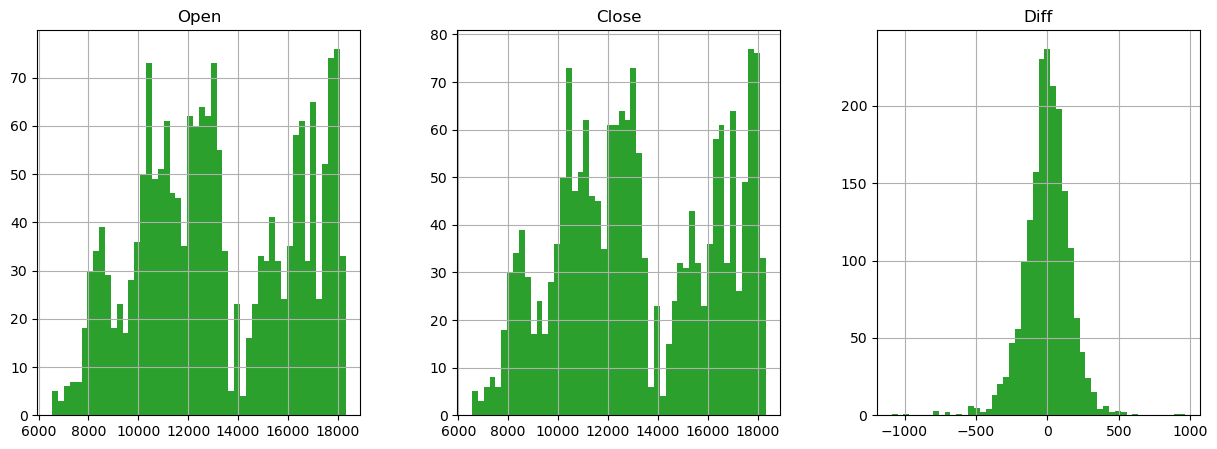

In [49]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for j in range(3):
    table_train.drop(['Date', 'Volume'], axis=1).hist(bins=50, ax=axs)    

Две величины из трех распределены ненормально, поэтому будем использовать нормализацию.   
Эмбеддинги обработаем с помощью PCA и KMeans.   
От обучающей выборки возьмем 20% для валидации.

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

seq_len = 10 # размер последовательности в LSTM
val_size = round(X.shape[0] * 0.2) # размер валидационной выборки
trn_size = X.shape[0] - val_size # размер обучающей выборки
X_sc, y_sc = MinMaxScaler(), MinMaxScaler()
pca_50 = PCA(n_components=50)
pca_train = pca_50.fit_transform(train_center[:-val_size*25])
pca_valid = pca_50.transform(train_center[-val_size*25-seq_len*25+1*25:])
pca_test = pca_50.transform(test_center)
clust = 5 # количество кластеров
news = 5 # количество новостей на дату, которые будем брать, первые новости должны быть самые значимые.
kmeans = KMeans(n_clusters=clust)
kmeans.fit(pca_train)
kmeans_train = np.hstack((kmeans.labels_.reshape(-1, 1),
                          kmeans.transform(pca_train)
                         )).reshape(trn_size, 25, clust+1)
X_train = np.hstack((X_sc.fit_transform(np.array(X[['Open', 'Diff']])[:-val_size]),
                       np.array(X[['Label']])[:-val_size],
                     kmeans_train[:, :news, :].reshape(trn_size, news*(clust+1))
                    ))
kmeans_valid = np.hstack((kmeans.predict(pca_valid).reshape(-1, 1),
                          kmeans.transform(pca_valid)
                         )).reshape(val_size+seq_len-1, 25, clust+1)
X_valid = np.hstack((X_sc.transform(np.array(X[['Open', 'Diff']])[-val_size-seq_len+1:]),
                       np.array(X[['Label']])[-val_size-seq_len+1:],
                     kmeans_valid[:, :news, :].reshape(val_size+seq_len-1, news*(clust+1))
                    ))
kmeans_test = np.hstack((kmeans.predict(pca_test).reshape(-1, 1),
                         kmeans.transform(pca_test)
                        )).reshape(X_sub.shape[0], 25, clust+1)
X_test = np.hstack((X_sc.transform(np.array(X_sub[['Open', 'Diff']])),
                       np.array(X_sub[['Label']]),
                     kmeans_test[:, :news, :].reshape(X_sub.shape[0], news*(clust+1))
                    ))
X_test = np.vstack((X_valid[-seq_len+1:], X_test))
y_train = y_sc.fit_transform(np.array(y)[seq_len-1:-val_size].reshape(-1, 1)).reshape(-1)
y_valid = y_sc.transform(np.array(y)[-val_size:].reshape(-1, 1)).reshape(-1)

X_train.shape

  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


(1490, 33)

Формируем датасеты и лоадеры.

In [55]:
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler

def create_dataset(X, y=None):
    seq_feat, seq_label = [], []
    size_data = X.shape[0]-seq_len+1
    for i in range(size_data):
        seq_feat.append(X[i:i+seq_len])
        if y is not None:
            seq_label.append(y[i:i+1])
    feat = np.concatenate(seq_feat).reshape(size_data, seq_len, X.shape[1])
    if y is not None:
        label = np.concatenate(seq_label)
        dataset = TensorDataset(torch.FloatTensor(feat), torch.FloatTensor(label))
    else:
        dataset = TensorDataset(torch.FloatTensor(feat))
    return dataset

train_dataset = create_dataset(X_train, y_train)
valid_dataset = create_dataset(X_valid, y_valid)
test_dataset = create_dataset(X_test)

train_sampler = SequentialSampler(train_dataset)
train_loader = DataLoader(train_dataset, sampler = train_sampler, batch_size = 16)
valid_sampler = SequentialSampler(valid_dataset)
valid_loader = DataLoader(valid_dataset, sampler = valid_sampler, batch_size = 16)
test_sampler = SequentialSampler(test_dataset)
test_loader = DataLoader(test_dataset, sampler = test_sampler, batch_size = 16)

Напишем класс нейросети и функции для ее.

In [58]:
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm1 = nn.LSTM(33, 1024, dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(1024, 512, dropout=0.3, batch_first=True)
        self.lstm3 = nn.LSTM(512, 256, dropout=0.3, batch_first=True)

        self.linear = nn.Sequential(
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.linear(x[:, -1, :])
        return x

In [60]:
from tqdm import tqdm

def train(model):
    model.train()

    train_loss = 0
    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        
        output = model(x) #.squeeze(1)

        loss = loss_fn(output, y) #y.float()

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [62]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        
        output = model(x) #.squeeze(1)

        loss = loss_fn(output, y) #y.float()

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [64]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [66]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    best_valid_loss = 1
    
    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        ) 
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'best_model.pth')

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Создадим сеть, оптимайзер и функцию потерь. Выставим веса для полносвязных слоев.

In [75]:
from torch.optim import Adam

model = Model().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss().to(device)

def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.xavier_uniform_(m.weight)

model.apply(weights_init)

Model(
  (lstm1): LSTM(33, 1024, batch_first=True, dropout=0.3)
  (lstm2): LSTM(1024, 512, batch_first=True, dropout=0.3)
  (lstm3): LSTM(512, 256, batch_first=True, dropout=0.3)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

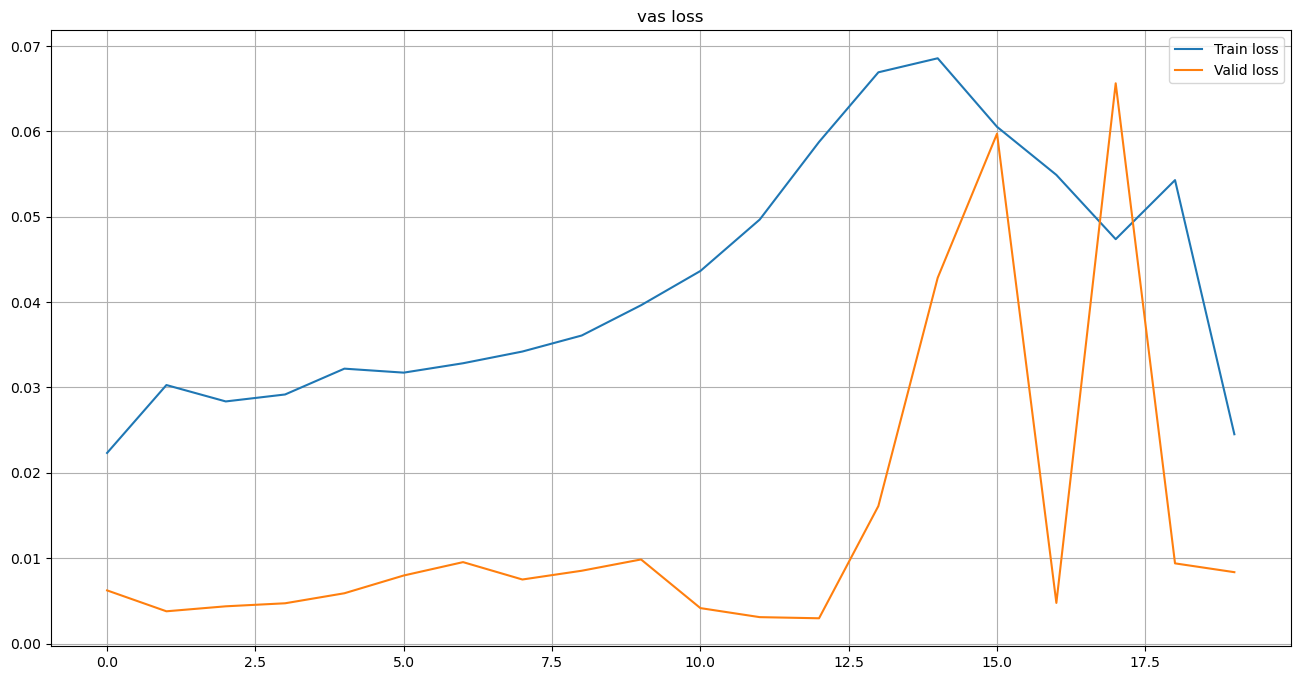

In [77]:
whole_train_valid_cycle(model, 20, 'vas')

Лучшая модель сохранится. Загрузим ее и сделаем предсказание для тестовой выборки. Результат обратно отмасштабируем, умножим на сто тысяч и сохраним.

In [80]:
best_model_cp = torch.load('best_model.pth')
model.load_state_dict(best_model_cp['model_state_dict'])

@torch.inference_mode()
def predict(model, loader):
    model.eval()

    total_sub = []
    for x in tqdm(loader, desc='Evaluation'):
        x = x[0].to(device)
        output = model(x)
        total_sub.append(output.cpu())

    return torch.cat(total_sub, dim=0)

preds = predict(model, test_loader).numpy()
preds = y_sc.inverse_transform(preds) * 100000
submission_df = pd.DataFrame({
    'Id': range(1, len(preds) + 1),
    'Close': preds.ravel()
})

submission_df.to_csv("submission.csv", index=False)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.67it/s]


После отправления результата на странице соревнования получим такую оценку: __11918977062801800__.   
Для сравнения вот оценка __16-го__ места: __19407614255964400__.